In [1]:
from modules.utils import *
from modules.YfScrapper import *
pd.set_option('display.max_columns', None)

## Part 1 Time Series Analysis

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import yfinance as yf
import matplotlib.pyplot as plt

### Stationarity
Differences need to be applied if data is not stationary.

C:\Users\stell\AppData\Local\Temp\ipykernel_8988\1261519973.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series.index = time_series.index.to_period('D')


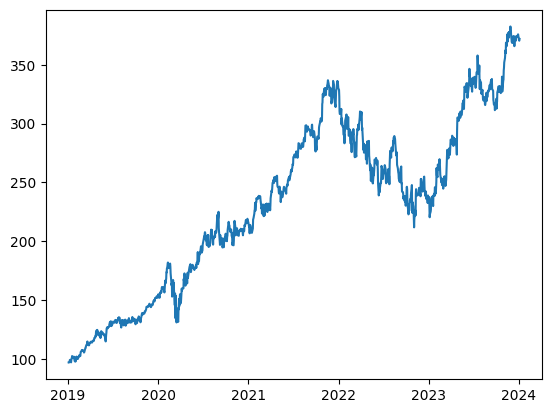

In [42]:
msft = yf.Ticker("MSFT")

# get all stock info
# msft.info

# get historical market data
df = msft.history(period='5y', interval='1d', )
time_series = df[['Close']].squeeze()
plt.plot(time_series)
time_series.index = time_series.index.to_period('D')

### Autocorrelation
This will help determine the lags to use for p. Choose a lag period which has high correlation to y.

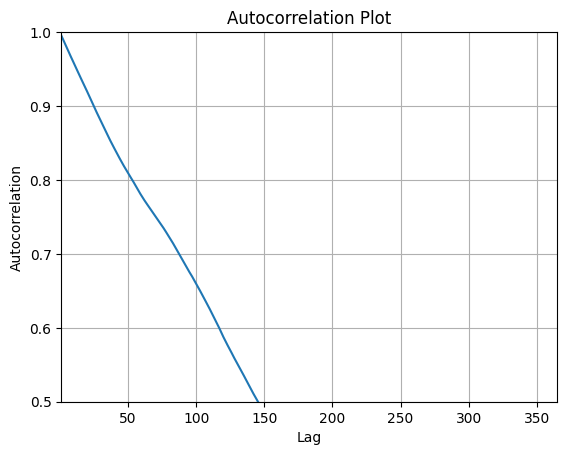

In [45]:
ax = autocorrelation_plot(time_series)
ax.set_title('Autocorrelation Plot')
ax.set_xlim(right=365)
ax.set_ylim(bottom=0.5)
plt.show()

### pdq of ARIMA
p: The lag order, representing the number of lag observations incorporated in the model.

d: Degree of differencing, denoting the number of times raw observations undergo differencing.

q: Order of moving average, indicating the size of the moving average window.


In [48]:
# From the graph above, data is not stationary, we will apply differences
model = ARIMA(time_series, order=(25, 1, 0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                ARIMA(25, 1, 0)   Log Likelihood               -3590.937
Date:                Thu, 04 Jan 2024   AIC                           7233.873
Time:                        23:38:05   BIC                           7367.442
Sample:                    01-04-2019   HQIC                          7284.070
                         - 01-04-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0865      0.022     -3.856      0.000      -0.130      -0.043
ar.L2         -0.0338      0.023     -1.453      0.146      -0.079       0.012
ar.L3         -0.0244      0.025     -0.979      0.3

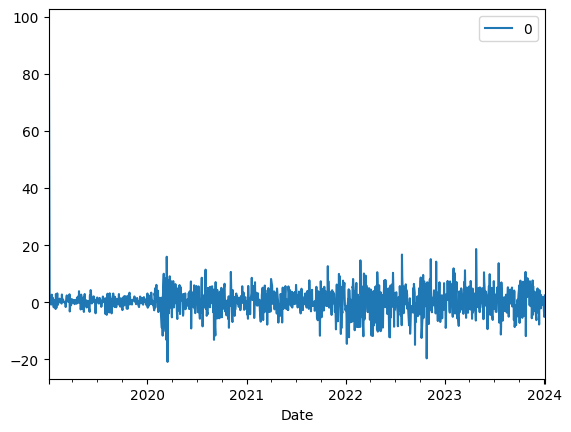

In [49]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

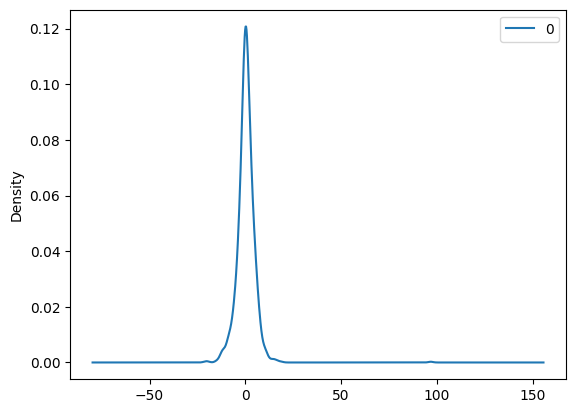

                 0
count  1259.000000
mean      0.333851
std       4.998610
min     -20.911068
25%      -1.798368
50%       0.271590
75%       2.600584
max      96.792442


In [50]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())